# Modelling

## Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from kmodes.kprototypes import KPrototypes
from sklearn.model_selection import cross_val_score
from yellowbrick.cluster import KElbowVisualizer
import lightgbm as lgb
import shap

## Loading Features

In [2]:
features = pd.read_csv('data/features.csv', index_col=0)
features

peak_dow_order_ratio  median_order_hour_of_day  \
user_id                                                   
1                        0.30                  0.369565   
2                        0.36                  0.434783   
3                        0.67                  0.695652   
4                        0.00                  0.565217   
5                        0.50                  0.739130   
...                       ...                       ...   
206205                   0.00                  0.652174   
206206                   0.39                  0.739130   
206207                   0.38                  0.521739   
206208                   0.31                  0.652174   
206209                   0.31                  0.565217   

         peak_hour_order_ratio  median_days_since_prior_order  \
user_id                                                         
1                         0.40                       0.650000   
2                         0.79                       0.383333   
3                         0.58                       0.333333   
4                         1.00                       0.500000   
5                         0.50                       0.350000   
...                        ...                            ...   
206205                    1.00                       0.333333   
206206                    0.39                       0.100000   
206207                    0.62                       0.266667   
206208                    0.69                       0.233333   
206209                    0.77                       0.600000   

         peak_dow_product_ratio  peak_hour_product_ratio  log_total_orders  \
user_id                                                                      
1                          0.29                     0.42          0.314271   
2                          0.33                     0.66          0.410627   
3                          0.70                     0.57          0.366170   
4                          0.00                     1.00          0.125965   
5                          0.57                     0.54          0.069323   
...                         ...                      ...               ...   
206205                     0.00                     1.00          0.000000   
206206                     0.43                     0.34          0.880187   
206207                     0.32                     0.61          0.449511   
206208                     0.26                     0.69          0.784662   
206209                     0.36                     0.77          0.389193   

         log_median_number_of_products  most_frequent_order_dow  \
user_id                                                           
1                             0.325807                        1   
2                             0.547593                        1   
3                             0.383203                        0   
4                             0.191601                        4   
5                             0.471231                        3   
...                                ...                      ...   
206205                        0.415761                        2   
206206                        0.253283                        0   
206207                        0.537893                        0   
206208                        0.537893                        2   
206209                        0.444885                        1   

         binarized_small_order_ratio  binarized_large_order_ratio  
user_id                                                            
1                                  0                            0  
2                                  0                            1  
3                                  0                            0  
4                                  1                            0  
5                                  0                            0  
...                             

Let's recollect the features we have engineered so far:

| index |            Feature            |     Type     | Level of Measurement | Log Scaled | Min-Max Scaled |
|:-----:|:-----------------------------:|:------------:|:--------------------:|:----------:|:--------------:|
|   0   |     peak_dow_order_ratio      | Quantitative |        Ratio         |     No     |      Yes       |
|   1   |   median_order_hour_of_day    | Quantitative |        Ratio         |     No     |      Yes       |
|   2   |     peak_hour_order_ratio     | Quantitative |        Ratio         |     No     |      Yes       |
|   3   | median_days_since_prior_order | Quantitative |        Ratio         |     No     |      Yes       |
|   4   |    peak_dow_product_ratio     | Quantitative |        Ratio         |     No     |      Yes       |
|   5   |    peak_hour_product_ratio    | Quantitative |        Ratio         |     No     |      Yes       |
|   6   |       log_total_orders        | Quantitative |        Ratio         |    Yes     |      Yes       |
|   7   | log_median_number_of_products | Quantitative |        Ratio         |    Yes     |      Yes       |
|   8   |    most_frequent_order_dow    | Categorical  |       Ordinal        |     No     |       No       |
|   9   |  binarized_small_order_ratio  | Categorical  |       Nominal        |     No     |       No       |
|  10   |  binarized_large_order_ratio  | Categorical  |       Nominal        |     No     |       No       |

In interest of time, we will only use a sample of the data for clustering. In practice, we would use the full dataset.

In [3]:
sampled_features = features.sample(n=10000, random_state=42)
sampled_features

peak_dow_order_ratio  median_order_hour_of_day  \
user_id                                                   
189033                   0.50                  0.630435   
113007                   0.33                  0.782609   
40369                    0.00                  0.630435   
2153                     0.47                  0.739130   
194850                   0.25                  0.652174   
...                       ...                       ...   
201787                   0.67                  0.543478   
51463                    0.00                  0.739130   
98243                    0.33                  0.478261   
122592                   0.75                  0.521739   
48104                    0.60                  0.434783   

         peak_hour_order_ratio  median_days_since_prior_order  \
user_id                                                         
189033                    0.38                       0.266667   
113007                    0.00                       0.100000   
40369                     0.62                       0.216667   
2153                      0.41                       0.166667   
194850                    0.84                       0.166667   
...                        ...                            ...   
201787                    0.50                       0.600000   
51463                     0.33                       0.133333   
98243                     0.25                       0.316667   
122592                    0.88                       0.250000   
48104                     0.49                       0.200000   

         peak_dow_product_ratio  peak_hour_product_ratio  log_total_orders  \
user_id                                                                      
189033                     0.51                     0.38          0.251930   
113007                     0.33                     0.00          0.000000   
40369                      0.00                     0.61          0.449511   
2153                       0.60                     0.46          0.467268   
194850                     0.28                     0.85          0.866170   
...                         ...                      ...               ...   
201787                     0.68                     0.45          0.366170   
51463                      0.00                     0.38          0.284662   
98243                      0.36                     0.31          0.366170   
122592                     0.75                     0.85          0.251930   
48104                      0.66                     0.46          0.682606   

         log_median_number_of_products  most_frequent_order_dow  \
user_id                                                           
189033                        0.471231                        0   
113007                        0.112080                        1   
40369                         0.517408                        3   
2153                          0.303681                        0   
194850                        0.458371                        4   
...                                ...                      ...   
201787                        0.614936                        0   
51463                         0.537893                        5   
98243                         0.365363                        3   
122592                        0.547593                        0   
48104                         0.556964                        1   

         binarized_small_order_ratio  binarized_large_order_ratio  
user_id                                                            
189033                             0                            0  
113007                             1                            0  
40369                              0                            0  
2153                               1                            0  
194850                             0                            0  
...                             

## Clustering

If there are both categorical and quantitative features, we can't use KMeans. Instead, we can use KPrototypes from the kmodes package.

2 is the minimum number of clusters to try. Let's start with that.

In [4]:
model = KPrototypes(n_clusters=2, init='Huang', n_init=50, random_state=42, max_iter=25, n_jobs=-1)
clusters = model.fit_predict(sampled_features.values, categorical=[8, 9, 10])

Let's visualize the epoch costs.

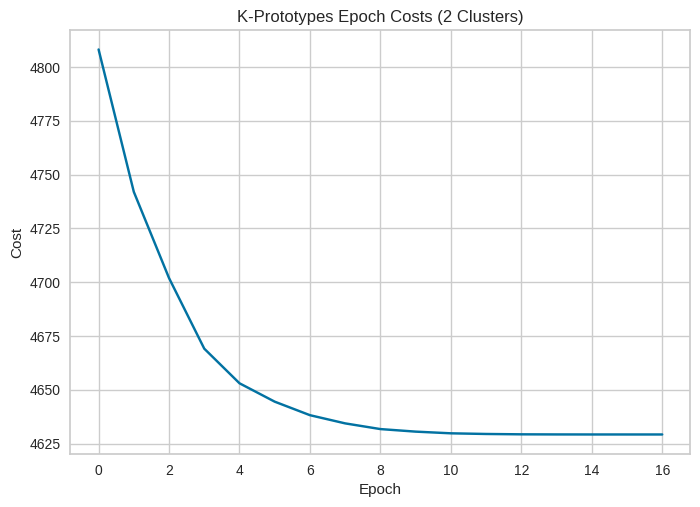

In [5]:
plt.plot(model.epoch_costs_)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('K-Prototypes Epoch Costs (2 Clusters)')
plt.show()

In [6]:
model.cost_

np.float64(4629.281798904355)

How are we going to select the number of clusters ? We typically use elbow method (i.e.) plot the cost for different number of clusters and look for an elbow in the plot. An elbow is a point where the cost starts decreasing at a slower rate.

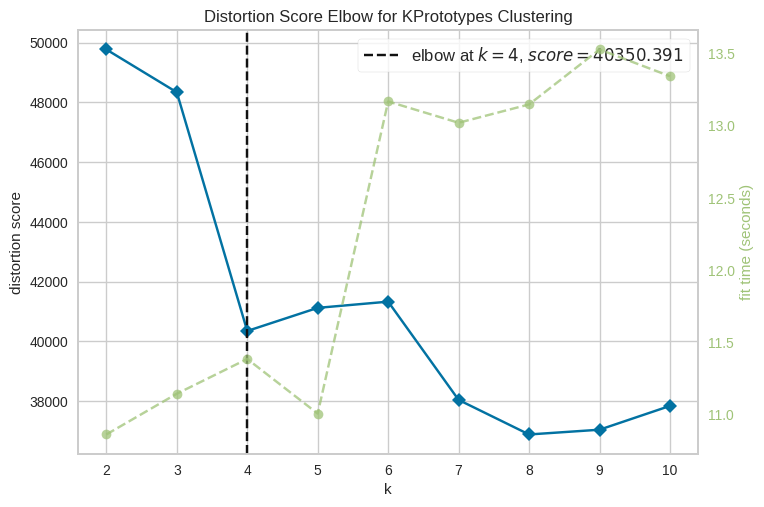

<Axes: title={'center': 'Distortion Score Elbow for KPrototypes Clustering'}, xlabel='k', ylabel='distortion score'>

In [7]:
model = KPrototypes(n_clusters=2, init='Huang', n_init=10, random_state=42, max_iter=25, n_jobs=-1)
visualizer = KElbowVisualizer(model, k=(2,11))
visualizer.fit(sampled_features.values, categorical=[8, 9, 10])
visualizer.show()

This confirms our hunch. There are other methods but let's fit the model with 4 clusters and see how the clusters look like.

In [8]:
model = KPrototypes(n_clusters=4, init='Huang', n_init=50, random_state=42, max_iter=25, n_jobs=-1)
clusters = model.fit_predict(sampled_features.values, categorical=[8, 9, 10])

In [9]:
results = sampled_features.copy(deep=True)
results['cluster_id'] = clusters
results.cluster_id.value_counts().sort_index()

cluster_id
0    2323
1    2356
2    2346
3    2975
Name: count, dtype: int64

Ok. Let's visualize the clusters using pairplot.

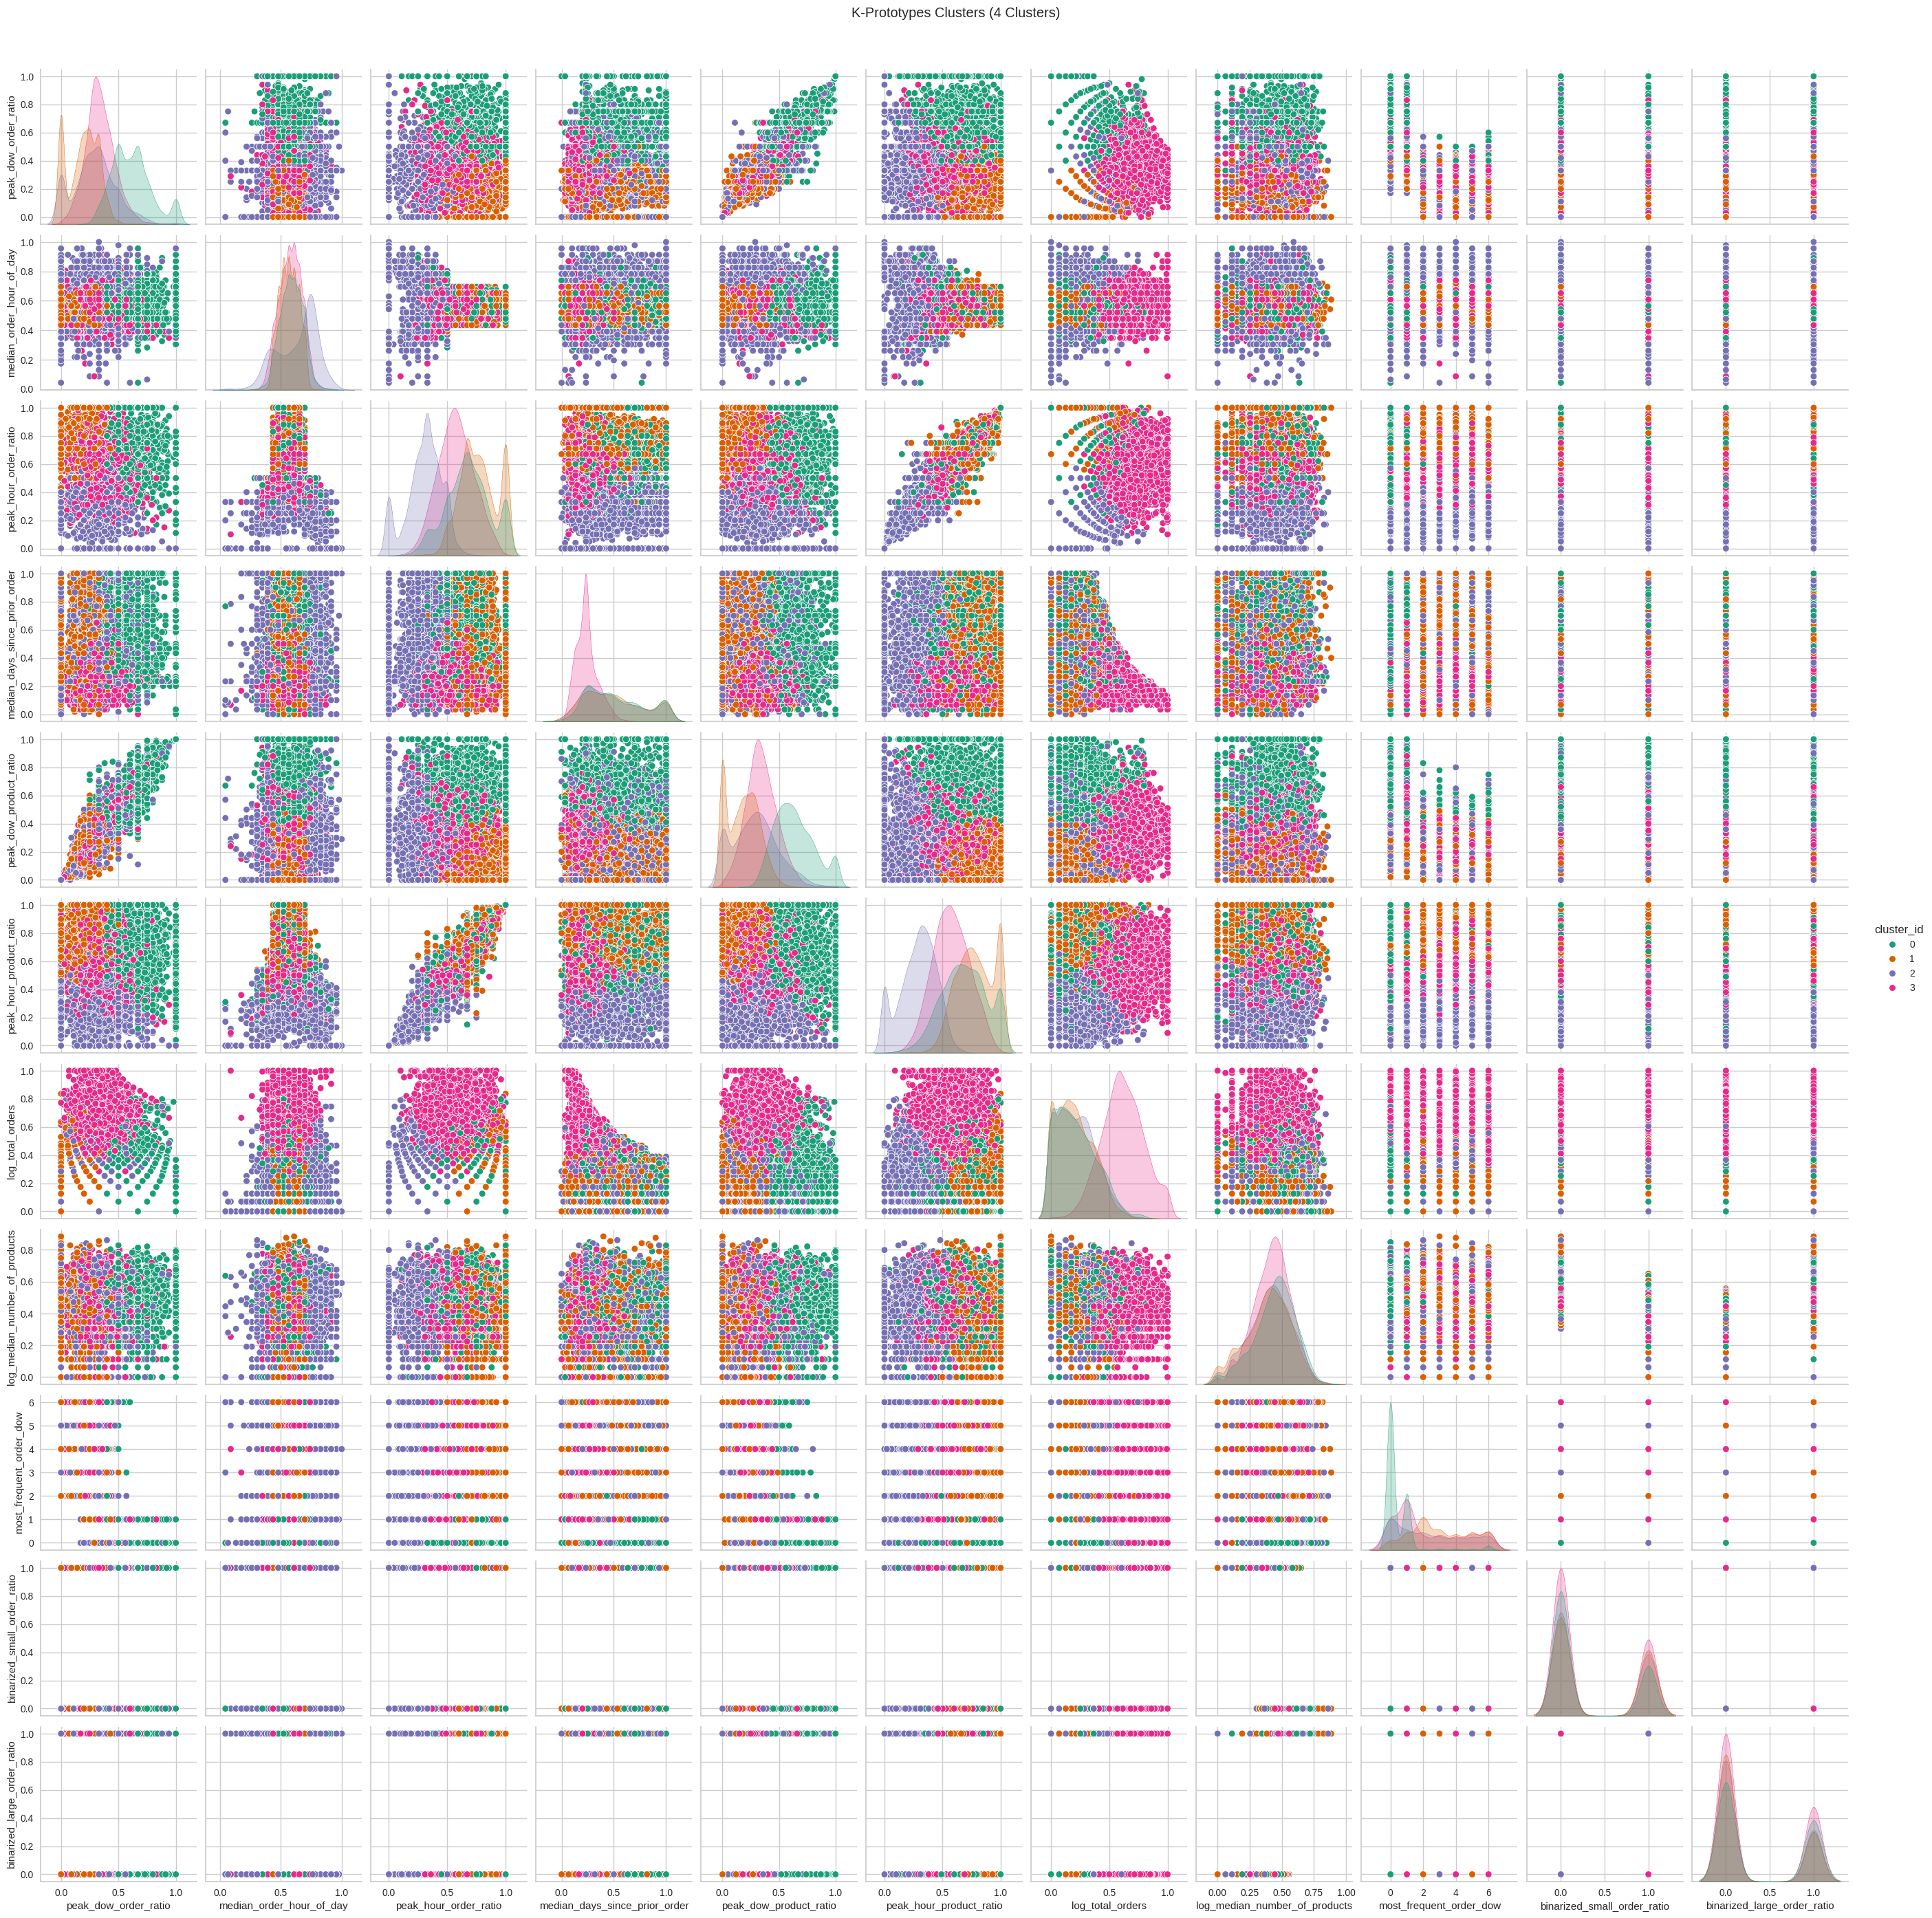

In [10]:
sns.pairplot(results, hue='cluster_id', diag_kind='kde', palette='Dark2')
plt.suptitle('K-Prototypes Clusters (4 Clusters)', y=1.02)
plt.show()

Usually, we try to interpret by looking at these plots / UMAP visualizations. However, with large dimensions, it is hard to interpret.

So we are going to use a different approach.

## Evaluation by Classification

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 660
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 11
[LightGBM] [Info] Start training from score -1.459726
[LightGBM] [Info] Start training from score -1.445620
[LightGBM] [Info] Start training from score -1.449873
[LightGBM] [Info] Start training from score -1.212341


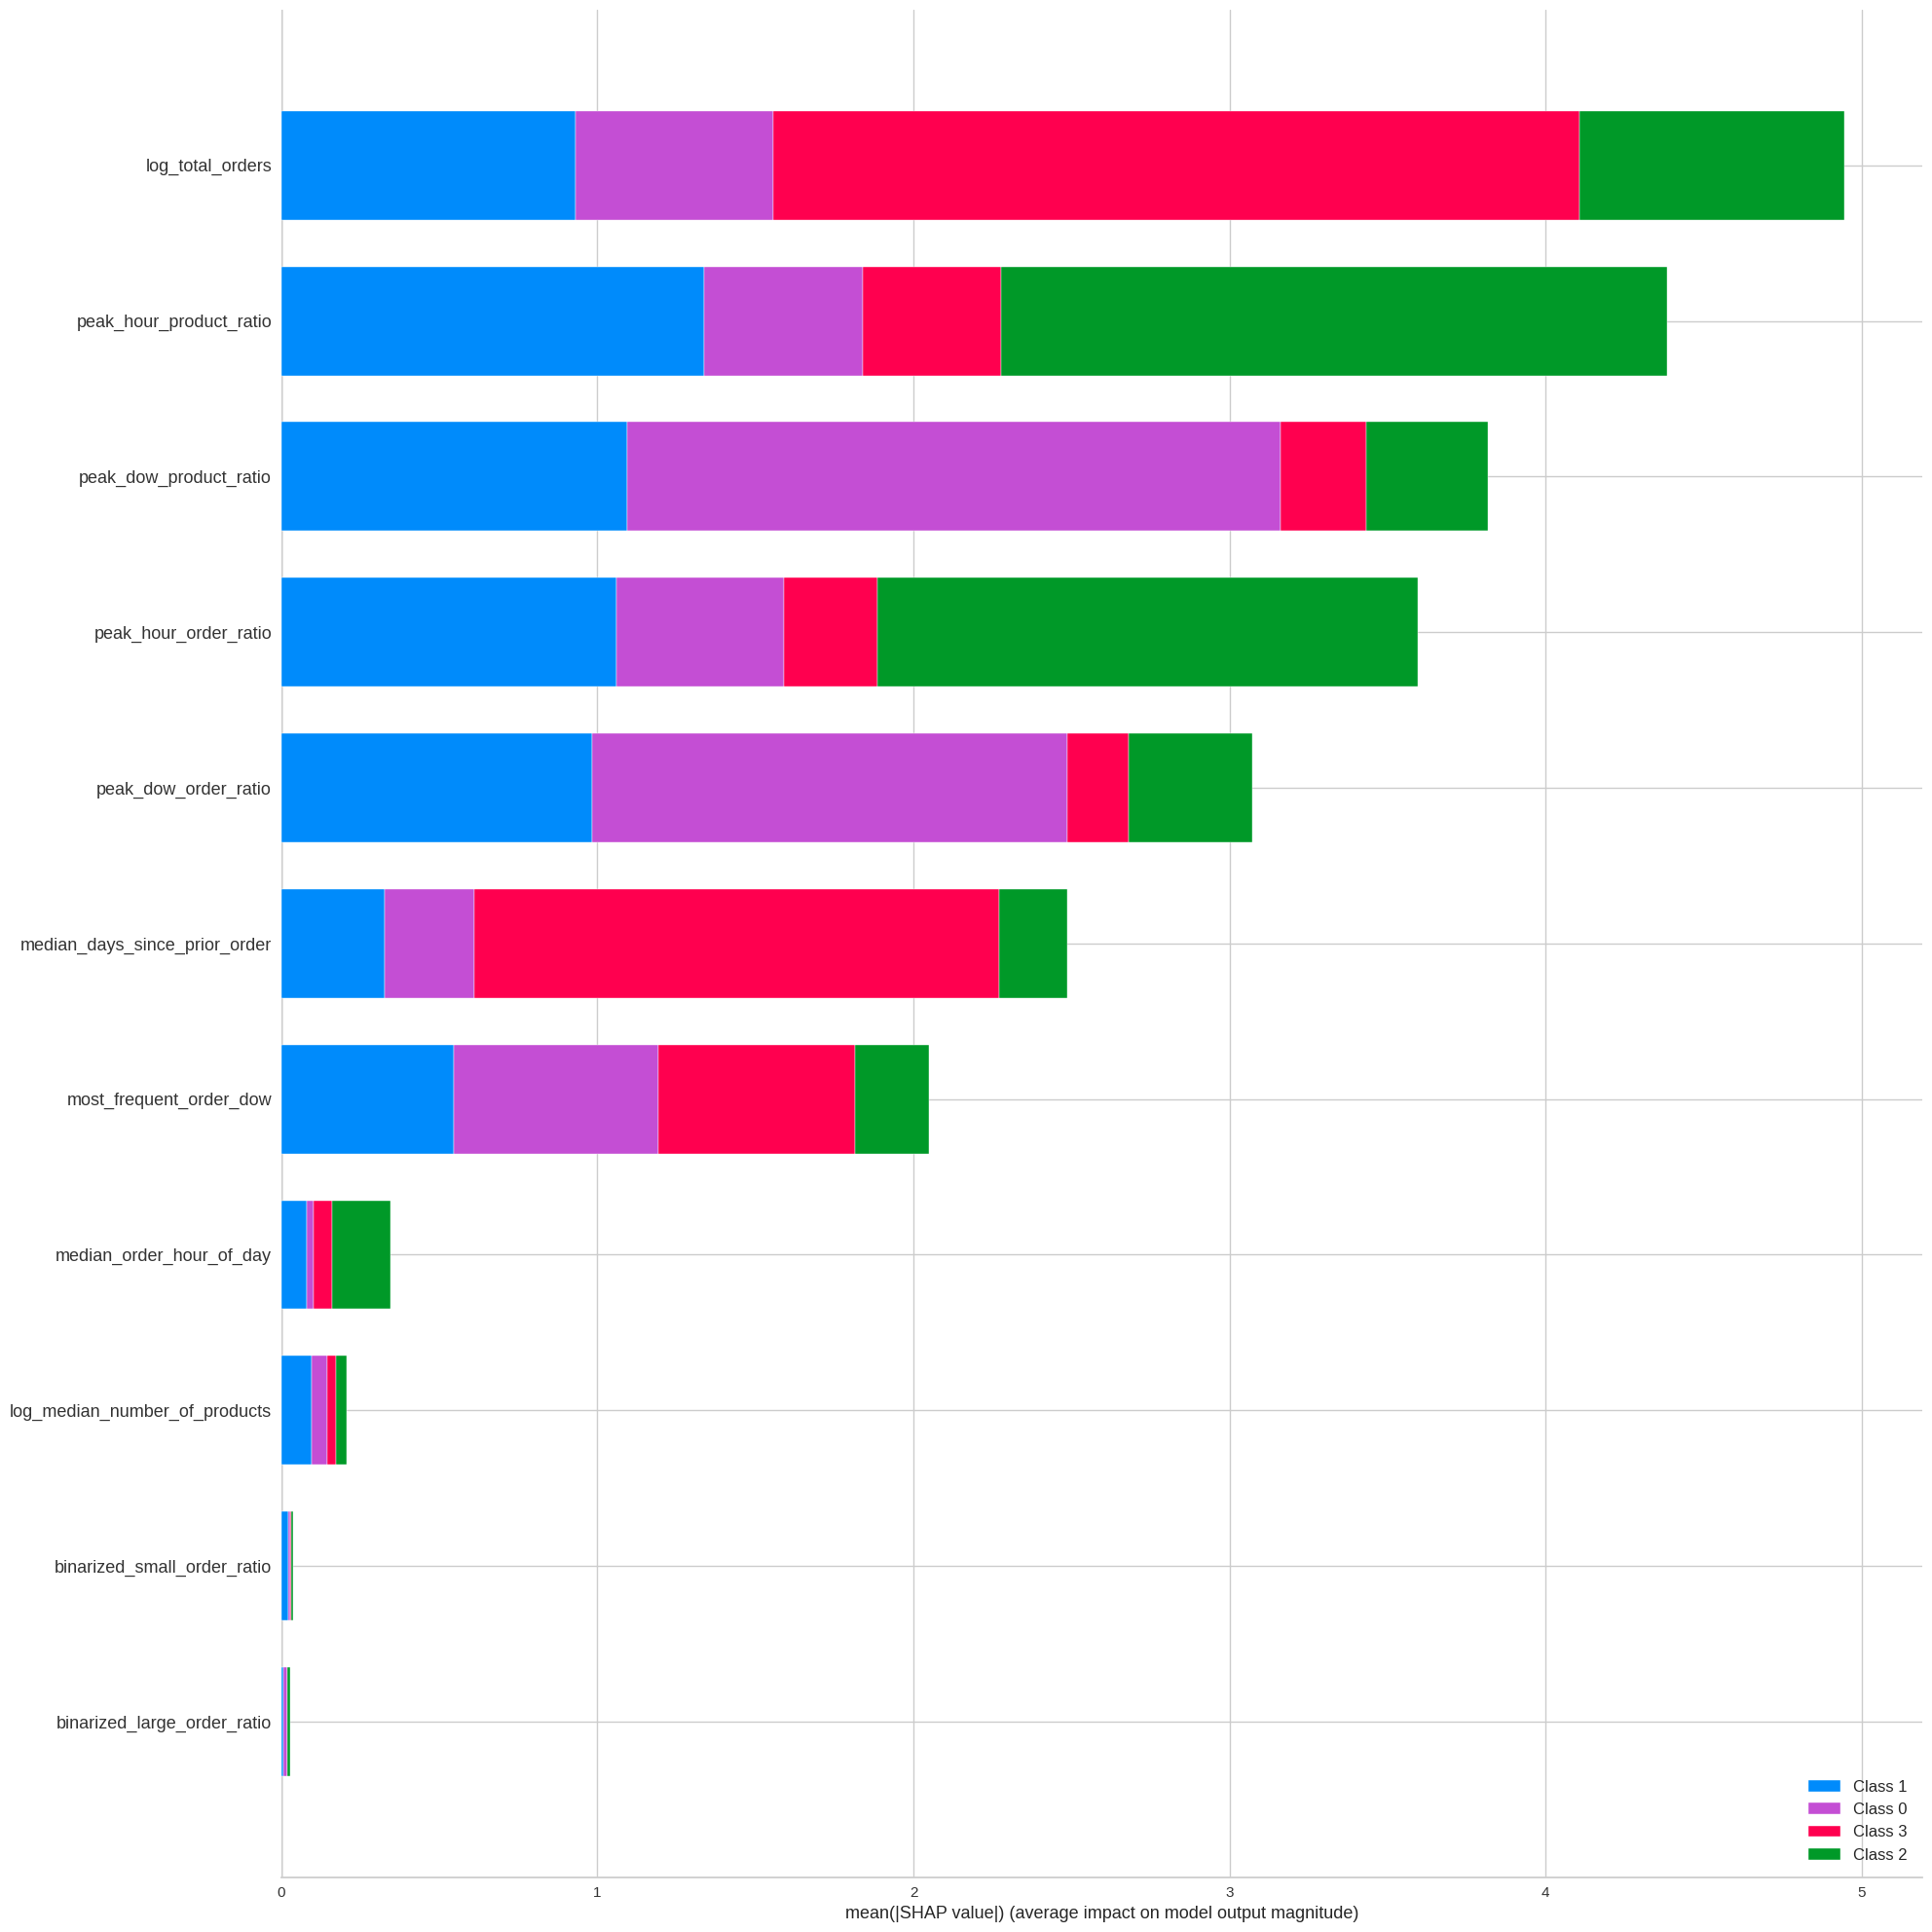

In [11]:
classifier = lgb.LGBMClassifier(random_state=42, n_jobs=-1, colsample_bytree=0.8)
classifier.fit(sampled_features, clusters)
tree_explainer = shap.TreeExplainer(classifier)
shap_values = tree_explainer.shap_values(sampled_features)
shap.summary_plot(shap_values, sampled_features, plot_type='bar', plot_size=(20,20))

- The shap summary plot indicates which features are important for classifying the clusters.
  - This gives us a hint about how to interpret the clusters.
  - For examples : Cluster 0 is highly influenced by `peak_dow_order_ratio` and `peak_dow_product_ratio`.
- To classify the clusters, the classifier had used 7 features extensively.
- Especially, `binarized_small_order_ratio` and `binarized_large_order_ratio` are the least important features.
- The features corresponding to date of order, time of order, lag between orders and total number of orders are important.
- Let's use cross-validation and check the F1-score to see if clusters are well-separated.

In [12]:
cross_validation_scores = cross_val_score(classifier, sampled_features, clusters, scoring='f1_weighted')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 652
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 11
[LightGBM] [Info] Start training from score -1.459403
[LightGBM] [Info] Start training from score -1.445514
[LightGBM] [Info] Start training from score -1.450300
[LightGBM] [Info] Start training from score -1.212341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 655
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 11
[LightGBM] [Info] Start training from score -1.459403
[LightGBM] [Info] Start training from score -1.446044
[LightGBM] [Info] Start training from 

In [13]:
cross_validation_scores.mean()

np.float64(0.9648054162095419)

The cross validation F1-score is very high (0.97). This indicates that the clusters are well-separated.